# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [263]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score  
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

import seaborn as sns  
from sklearn.metrics import confusion_matrix  


# % matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

In [264]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [265]:
print("Number of different offers: ", portfolio.shape[0])
print(portfolio.groupby("offer_type")["id"].count())

Number of different offers:  10
offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64


## Remove Missing Values
Check for missing data. If there are rows with NA values drop them.

Only the profile data set contained missing values. The transcript and portfolio dataset didn't have any NA values.

In [266]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [267]:
profile_cleaned = profile.dropna()
print("Profile shape:", profile.shape)
print("Profile cleaned shape:", profile_cleaned.shape)

Profile shape: (17000, 5)
Profile cleaned shape: (14825, 5)


In [268]:
profile_cleaned.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


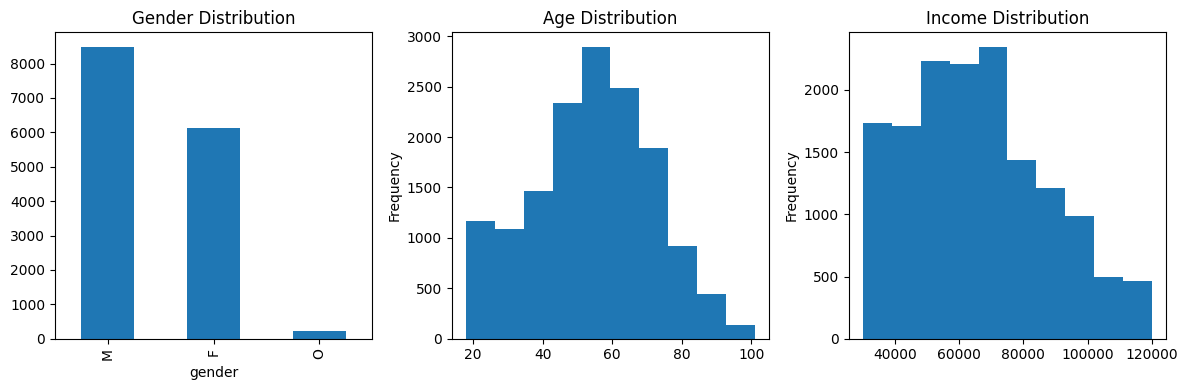

In [269]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  
 
profile_cleaned['gender'].value_counts().plot(kind='bar', ax=axes[0])  
axes[0].set_title('Gender Distribution')  

profile_cleaned['age'].plot(kind='hist', bins=10, ax=axes[1]) 
axes[1].set_title('Age Distribution')  

profile_cleaned['income'].plot(kind='hist', bins=10, ax=axes[2])   
axes[2].set_title('Income Distribution')  

plt.tight_layout()  

In [270]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [271]:
print("Type of events: ", transcript["event"].unique())

Type of events:  ['offer received' 'offer viewed' 'transaction' 'offer completed']


In [272]:
received_offer = transcript["value"].loc[transcript["event"] == "offer received"].reset_index(drop= True)
print(received_offer[0])
viewed_offer = transcript["value"].loc[transcript["event"] == "offer viewed"].reset_index(drop= True)
print(viewed_offer[0])
complete_offer = transcript["value"].loc[transcript["event"] == "offer completed"].reset_index(drop= True)
print(complete_offer[0])
transaction = transcript["value"].loc[transcript["event"] == "transaction"].reset_index(drop= True)
print(transaction[0])

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}
{'amount': 0.8300000000000001}


<Axes: xlabel='event'>

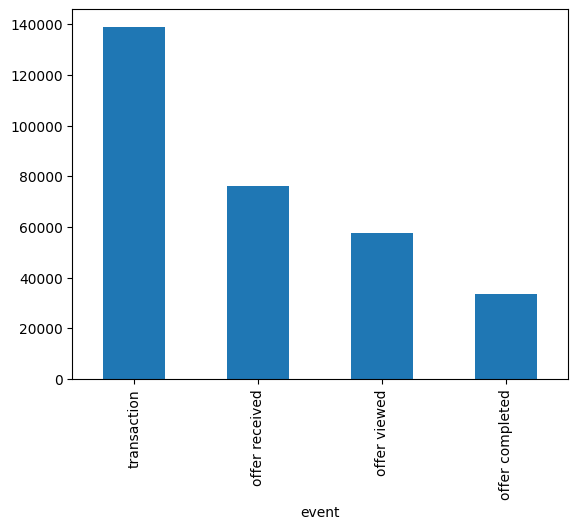

In [273]:
fig = plt.figure()

transcript["event"].value_counts().plot(kind="bar")

# Encode Data

## Encode Portfolio Data
- one hot encode the channels column
- one hot encode offer type

In [274]:
channel_types = ['web', 'email', 'mobile', 'social']  
  
for channel in channel_types:  
    portfolio[channel] = portfolio['channels'].apply(lambda x: int(channel in x))  

portfolio_encoded = portfolio.drop('channels', axis=1) 

offer_dummies = pd.get_dummies(portfolio_encoded['offer_type'])  
offer_dummies = offer_dummies.astype(int)  
portfolio_encoded = pd.concat([portfolio_encoded, offer_dummies], axis=1)  

portfolio_encoded.rename(columns = {"id": "offer_id", "reward": "obtainable_reward"}, inplace = True)
portfolio_encoded

,obtainable_reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


## Encode Profile Data

- one hot encode the gender column


In [275]:
gender_dummies = pd.get_dummies(profile_cleaned['gender'])  
gender_dummies = gender_dummies.astype(int)  
profile_encoded = pd.concat([profile_cleaned, gender_dummies], axis=1)  
# profile_encoded = profile_encoded.drop('gender', axis=1)    
profile_encoded.rename(columns = {"id": "person_id"}, inplace= True)


profile_encoded.head()

,gender,age,person_id,became_member_on,income,F,M,O
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0,1,0


### Encode Transcript Data

- Retrieve offer id and reward in seaprate columns
- one hot encode the event column

In [276]:
def extract_offer_id(row): 
    try: 
        return row['value']['offer id'] if 'offer id' in row['value'] else row['value']['offer_id'] 
    except KeyError:
        pass

def extract_reward(row):
    try:
        return row["value"]["reward"] 
    except KeyError:
        pass

def extract_amount(row):
    try:
        return row["value"]["amount"] 
    except KeyError:
        pass

In [277]:
transcript["offer_id"] = transcript.apply(extract_offer_id, axis = 1)
transcript["reward"] = transcript.apply(extract_reward, axis=1)
transcript["amount"] = transcript.apply(extract_amount, axis = 1)

transcript.head()

,person,event,value,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [278]:
event_dummies = pd.get_dummies(transcript['event'])  
event_dummies = event_dummies.astype(int)  
transcript_encoded = pd.concat([transcript, event_dummies], axis=1)  
transcript_encoded = transcript_encoded.drop('value', axis=1)   
transcript_encoded.rename(columns = {"person": "person_id", "reward": "obtained_reward"}, inplace = True) 

transcript_encoded.head()

,person_id,event,time,offer_id,obtained_reward,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


# Merge Dataframes

In [279]:
df_merged = pd.merge(transcript_encoded, profile_encoded, how= "inner", on = "person_id")
df_merged = pd.merge(df_merged, portfolio_encoded, how= "inner", on= "offer_id")
df_merged

,person_id,event,time,offer_id,obtained_reward,amount,offer completed,offer received,offer viewed,transaction,...,difficulty,duration,offer_type,web,email,mobile,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,...,5,7,bogo,1,1,1,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,0,1,0,...,5,7,bogo,1,1,1,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,1,0,0,0,...,5,7,bogo,1,1,1,0,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,...,5,7,bogo,1,1,1,0,1,0,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,0,1,0,...,5,7,bogo,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148800,8578196a074a4f328976e334fa9383a3,offer viewed,504,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,0,1,0,...,10,5,bogo,1,1,1,1,1,0,0
148801,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0,...,10,5,bogo,1,1,1,1,1,0,0
148802,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,0,1,0,...,10,5,bogo,1,1,1,1,1,0,0
148803,3045af4e98794a04a5542d3eac939b1f,offer received,576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0,...,10,5,bogo,1,1,1,1,1,0,0


# Feature Engineering 

- duration_membership
- total number of received offers
- total number of completed offers

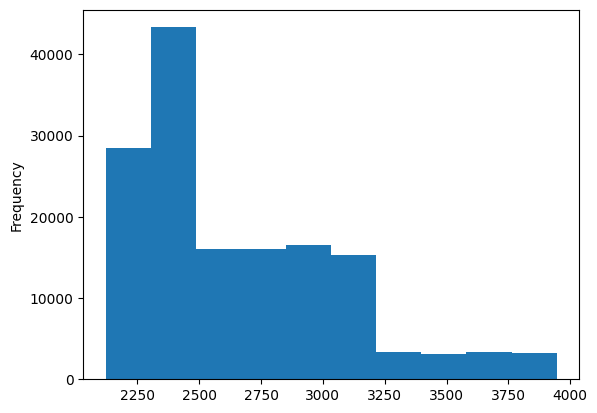

In [280]:
import datetime

today = datetime.datetime.today()
df_merged["duration_membership"] = (today - pd.to_datetime(df_merged["became_member_on"], format = "%Y%m%d")).dt.days

df_merged["startyear_member"] = pd.to_datetime(df_merged["became_member_on"], format = "%Y%m%d").dt.year
df_merged["startmonth_member"] = pd.to_datetime(df_merged["became_member_on"], format = "%Y%m%d").dt.month

df_merged['duration_membership'].plot(kind='hist', bins=10) 
plt.show()

It looks like there are significant drops in the length of memeberships after 2500 days and 3250 days. 

In [281]:
df_merged.head()

,person_id,event,time,offer_id,obtained_reward,amount,offer completed,offer received,offer viewed,transaction,...,web,email,mobile,social,bogo,discount,informational,duration_membership,startyear_member,startmonth_member
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,...,1,1,1,0,1,0,0,2565,2017,5
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,0,1,0,...,1,1,1,0,1,0,0,2565,2017,5
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,1,0,0,0,...,1,1,1,0,1,0,0,2565,2017,5
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,...,1,1,1,0,1,0,0,2213,2018,4
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,0,1,0,...,1,1,1,0,1,0,0,2213,2018,4


In [282]:
df_merged.columns

Index(['person_id', 'event', 'time', 'offer_id', 'obtained_reward', 'amount',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'gender', 'age', 'became_member_on', 'income', 'F', 'M', 'O',
       'obtainable_reward', 'difficulty', 'duration', 'offer_type', 'web',
       'email', 'mobile', 'social', 'bogo', 'discount', 'informational',
       'duration_membership', 'startyear_member', 'startmonth_member'],
      dtype='object')

In [283]:
df_fe["income"].max()

120000.0

In [284]:
total_offer_received = df_merged.groupby("person_id")["offer received"].sum().reset_index()
total_offer_received.rename(columns = {"offer received": "total_offers_received"}, inplace= True)

# total_viewed_offers = df_merged.groupby("person_id")["offer viewed"].sum().reset_index()
# total_viewed_offers.rename(columns= {"offer viewed": "total_viewed_offers"}, inplace= True)

df_fe = pd.merge(df_merged, total_offer_received, how= "left", on= "person_id")
# df_fe = pd.merge(df_fe, total_viewed_offers, how="left", on="person_id")


# Define the age bins and labels  
bins = [0, 20, 40, 60, 80, 110]  
# label 1: 0-20, label 2: 21-40, label 3: 41-60, label 4: 61-80, label 5: 81 -110
labels = [1, 2, 3, 4, 5]  
# Create a new column with the age ranges  
df_fe['age_ranges'] = pd.cut(df_fe['age'], bins=bins, labels=labels, right=False)  

# Define the income bins and labels  
bins = [0, 50000, 80000, 100000, 130000]  
# label 1: 0-50000, label 2: 50000 - 80000, label 3: 80000 - 100000, label 4: +100000 - 130000
labels = [1, 2, 3, 4]  
# Create a new column with the age ranges  
df_fe['income_ranges'] = pd.cut(df_fe['age'], bins=bins, labels=labels, right=False)  



In [285]:
df_fe.columns


Index(['person_id', 'event', 'time', 'offer_id', 'obtained_reward', 'amount',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'gender', 'age', 'became_member_on', 'income', 'F', 'M', 'O',
       'obtainable_reward', 'difficulty', 'duration', 'offer_type', 'web',
       'email', 'mobile', 'social', 'bogo', 'discount', 'informational',
       'duration_membership', 'startyear_member', 'startmonth_member',
       'total_offers_received', 'age_ranges', 'income_ranges'],
      dtype='object')

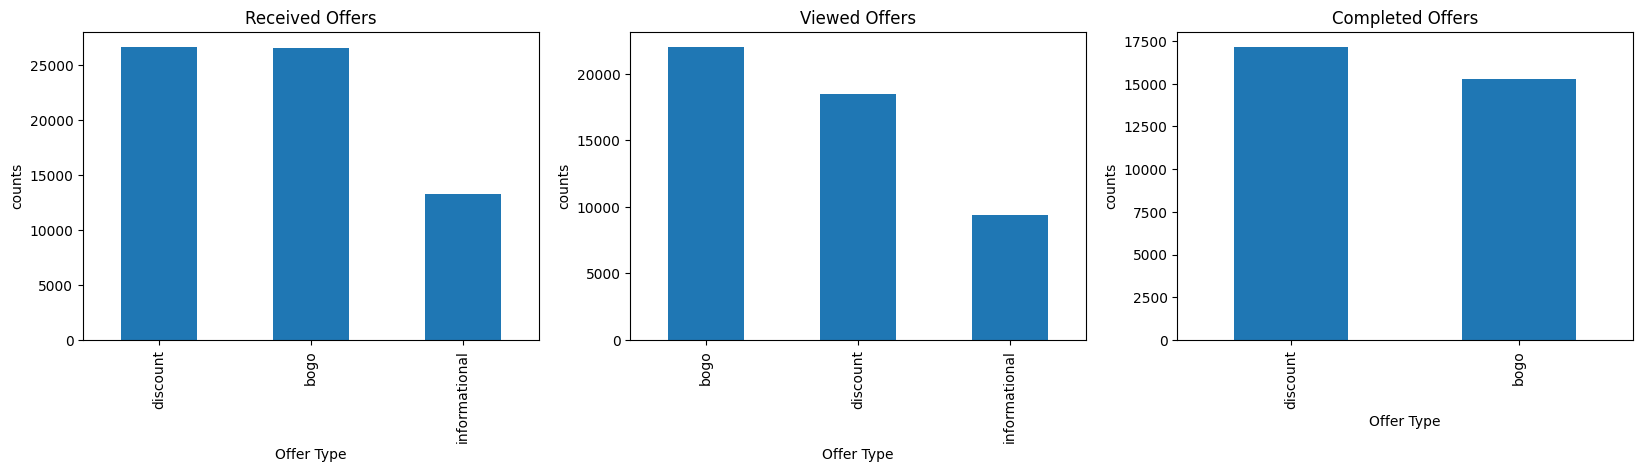

In [286]:
plt.figure(figsize=(20,4))
plt.subplot(131)
offer_received = df_fe[df_fe["offer received"] == 1].offer_type.value_counts()
offer_received.plot(kind = "bar")
plt.ylabel("counts")
plt.xlabel("Offer Type")
plt.title("Received Offers")

plt.subplot(132)
offer_viewed = df_fe[df_fe["offer viewed"] == 1].offer_type.value_counts()
offer_viewed.plot(kind = "bar")
plt.ylabel("counts")
plt.xlabel("Offer Type")
plt.title("Viewed Offers")

plt.subplot(133)
offer_viewed = df_fe[df_fe["offer completed"] == 1].offer_type.value_counts()
offer_viewed.plot(kind = "bar")
plt.ylabel("counts")
plt.xlabel("Offer Type")
plt.title("Completed Offers")
plt.show()

In [287]:
FEATURES = ['time', 'offer completed', 'offer received',
       'age', 'became_member_on', 'income', 'F', 'M', 'O',
       'obtainable_reward', 'difficulty', 'duration', 'web',
       'email', 'mobile', 'social', 'duration_membership',
       'bogo', 'discount', 'informational', 'startyear_member', 'startmonth_member',
       'total_offers_received', 'age_ranges', 'income_ranges']

#  'offer viewed',

TARGET = "offer completed"

data = df_fe[FEATURES]
data = data.dropna()

I kept the offer received event in the features and used it as a cut off point. So the information if the customer viewed the offer or not is not used as a feature for the prediction models. I chose this cut off point because Starbucks can control which customer it sends its offers to. However, it has no control over the fact if a customer will view it or not. Furthermore, if the customer did not receive an offer, the issue of the offer not being completed is not due to the fact that the customer wasn't interested in the offer but due to other technical issues.

# Split data into training and test set

Use the stratify argument to account for class imbalances in the data split

In [288]:
# features and target 
X = data.drop(columns= [TARGET])
y = data[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

In [289]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((104163, 24), (104163,), (44642, 24), (44642,))

In [290]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104163 entries, 109336 to 84129
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   time                   104163 non-null  int64   
 1   offer received         104163 non-null  int64   
 2   age                    104163 non-null  int64   
 3   became_member_on       104163 non-null  int64   
 4   income                 104163 non-null  float64 
 5   F                      104163 non-null  int64   
 6   M                      104163 non-null  int64   
 7   O                      104163 non-null  int64   
 8   obtainable_reward      104163 non-null  int64   
 9   difficulty             104163 non-null  int64   
 10  duration               104163 non-null  int64   
 11  web                    104163 non-null  int64   
 12  email                  104163 non-null  int64   
 13  mobile                 104163 non-null  int64   
 14  social               

### Feature Scaling

I keep the unscaled X_train and X_test dataframes as random forests don't rely on scaled features. 

In [291]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled["income"] = scaler.fit_transform(X_train_scaled["income"].values.reshape(-1, 1))
X_test_scaled["income"] = scaler.transform(X_test_scaled["income"].values.reshape(-1, 1))

X_train_scaled["age"] = scaler.fit_transform(X_train_scaled["age"].values.reshape(-1, 1))
X_test_scaled["age"] = scaler.transform(X_test_scaled["age"].values.reshape(-1, 1))

In [292]:
X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis = 1)

X_train_scaled.reset_index(inplace=True)
X_train_scaled = X_train_scaled.drop(['index'], axis = 1)


X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis = 1)

X_test_scaled.reset_index(inplace=True)
X_test_scaled = X_test_scaled.drop(['index'], axis = 1)

# Baseline model: Logistic Regression

In [293]:
LogReg = LogisticRegression()
LogReg.fit(X_train_scaled, y_train)
y_pred = LogReg.predict(X_test_scaled)

# Perform cross-validation with 5 folds  
cv_scores = cross_val_score(LogReg, X_train_scaled, y_train, cv=5)  
  
# Print the scores for each fold  
print("Cross-validation scores:", cv_scores)  
  
# Calculate and print the mean score  
mean_cv_score = np.mean(cv_scores)  
print("Mean cross-validation score:", mean_cv_score)  

Cross-validation scores: [0.78198051 0.78198051 0.78193251 0.78197005 0.78197005]
Mean cross-validation score: 0.7819667252924895


In [294]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))

0.7819766139509878
0.6863024127016639
0.7819766139509878
0.6114874247662523


/Users/p409809/anaconda3/envs/DataScience/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


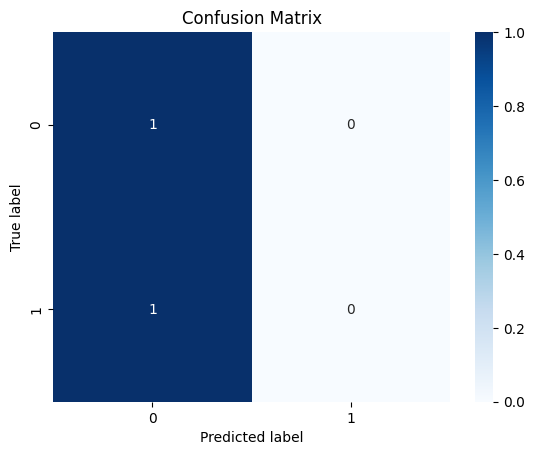

In [295]:
cm = confusion_matrix(y_test, y_pred)  
  
# Normalize the confusion matrix  
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
  
# Plot the confusion matrix  
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=LogReg.classes_, yticklabels=LogReg.classes_)  
plt.xlabel('Predicted label')  
plt.ylabel('True label')  
plt.title('Confusion Matrix')  
plt.show()  

## Outcome Logistic Regression: 
The Logistic Regression always predicts the majority class which is "offer not completed". The Accuracy is still high which indicates that the dataset is imbalanced. Even though, the accuracy score is rather high the model fails to predict if an offer will be successfull or not.

# LGBM Model

In [296]:
# Hiperparam Search
PARAMS_LIGHTGBM = {
    # Boosting
    'learning_rate': [0.01, 0.05], # Small Learning Rate to prevent overfitting
    'n_estimators': [50, 200, 500], # Amount of Decision trees to build.
    'boosting_type' : ['gbdt'],
     # Decision Tree 
    'num_leaves': [2, 5, 10], # more leaves lead to overfitting with so few data
    'min_data_in_leaf': [5, 20], # Related to num_leaves
    'max_depth' : [2, 5,], # Related to num leaves. More depth increases overfitting chance
    'colsample_bytree' : [0.5, 0.9], # % of features to take in as input for each tree
    'bagging_freq': [0, 1, 5], # Freq for using bagging in each tree input
    'subsample' : [0.5, 0.9], # % of samples to take in as input for each tree
    'reg_lambda': [0.01, 0.05, 1], # Regularization param to avoid overfitting
    'extra_trees': [True, False],
    'objective': ['binary'], # Multiclass classification  
    'metric':['binary_logloss'], # Use multi_logloss for multiclass classification  
    'verbose': [-1] # Verbose of LGBM API
}

In [297]:
from sklearn.utils import class_weight  
from sklearn.multiclass import OneVsRestClassifier  
from sklearn.metrics import make_scorer
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold  
  

# Notebook Variables
SEED = 2105
CV = 5
N_ITER = 5

# Create a StratifiedKFold object  
stratified_kfold = StratifiedKFold(n_splits=CV, shuffle=True, random_state=SEED)


# Calculate class weights  
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)  
class_weights = dict(enumerate(weights))  
  
lgbm = LGBMClassifier(class_weight=class_weights, random_state=SEED)  

# Get Classification Evaluation Metric here: accuracy 
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)  

# Hiperparam Grid Serach

gsearch = RandomizedSearchCV(lgbm, 
                        PARAMS_LIGHTGBM, 
                        scoring='accuracy',
                        cv=stratified_kfold, 
                        return_train_score=True, # To check overfitting
                        verbose=2, # GS Verbosity
                        random_state=SEED,
                        n_iter=N_ITER) # Ver si shuffle True or False!

gsearch.fit(X_train, y_train)

lgbm = LGBMClassifier(**gsearch.best_params_, random_state=SEED)
        
# lgbm = lgbm.fit(X_train, y_train, 
#             eval_metric='multi_logloss', 
#             eval_set = [(X_valid, y_valid)],
#             callbacks=[lgb.early_stopping(10)])   

# cv_results = pd.DataFrame(gsearch.cv_results_, 
#                         columns=gsearch.cv_results_.keys())

lgbm.fit(X_train, y_train)


y_pred = lgbm.predict(X_test)

print('Test Accuracy Score: ', accuracy_score(y_test, lgbm.predict(X_test)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END bagging_freq=0, boosting_type=gbdt, colsample_bytree=0.5, extra_trees=True, learning_rate=0.05, max_depth=2, metric=binary_logloss, min_data_in_leaf=5, n_estimators=200, num_leaves=5, objective=binary, reg_lambda=1, subsample=0.9, verbose=-1; total time=   0.4s
[CV] END bagging_freq=0, boosting_type=gbdt, colsample_bytree=0.5, extra_trees=True, learning_rate=0.05, max_depth=2, metric=binary_logloss, min_data_in_leaf=5, n_estimators=200, num_leaves=5, objective=binary, reg_lambda=1, subsample=0.9, verbose=-1; total time=   0.3s
[CV] END bagging_freq=0, boosting_type=gbdt, colsample_bytree=0.5, extra_trees=True, learning_rate=0.05, max_depth=2, metric=binary_logloss, min_data_in_leaf=5, n_estimators=200, num_leaves=5, objective=binary, reg_lambda=1, subsample=0.9, verbose=-1; total time=   0.3s
[CV] END bagging_freq=0, boosting_type=gbdt, colsample_bytree=0.5, extra_trees=True, learning_rate=0.05, max_depth=2, metric=bi

In [298]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))

0.8160252676851395
0.7921578123927477
0.8160252676851395
0.7964421205146687


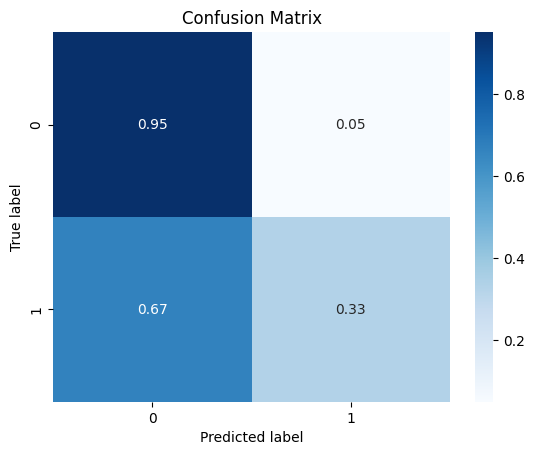

In [299]:
import seaborn as sns  
from sklearn.metrics import confusion_matrix  
  
# Get the predicted class labels  
y_pred = lgbm.predict(X_test)  
  
# Compute the confusion matrix  
cm = confusion_matrix(y_test, y_pred)  
  
# Normalize the confusion matrix  
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
  
# Plot the confusion matrix  
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=lgbm.classes_, yticklabels=lgbm.classes_)  
plt.xlabel('Predicted label')  
plt.ylabel('True label')  
plt.title('Confusion Matrix')  
plt.show()  

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

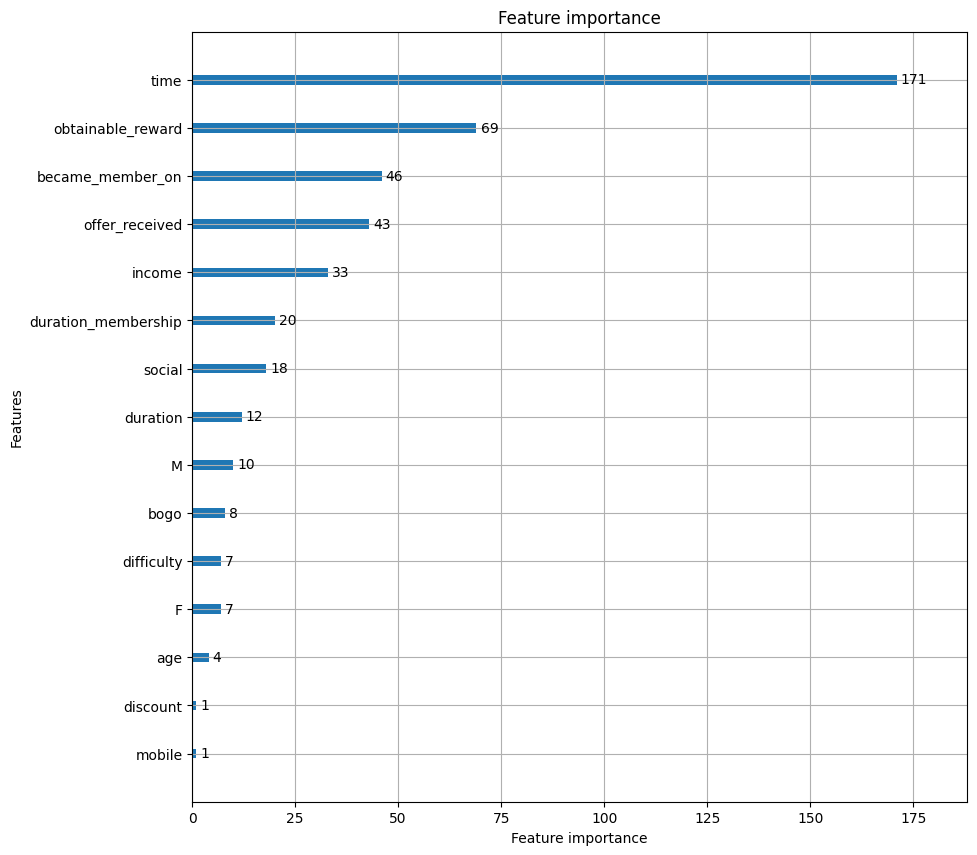

In [300]:
lgb.plot_importance(lgbm,  max_num_features=30, ignore_zero=True, figsize=(10,10))

# Model Evaluation
### Results Baseline Model
- Accuracy: 0.7819766139509878
- F1 Score: 0.6863024127016639
- Recall: 0.7819766139509878
- Precision: 0.6114874247662523

### Results Baseline Model
- Accuracy: 0.8175036960709645
- F1 Score: 0.7906974343151982
- Recall: 0.8175036960709645
- Precision: 0.7989888103183717

# Model Interpretation
The most important feature of the LGBM model is time followed by the obtainable reward of the offer and when the customer became a member.
The most important demographic feature is the income of the customer. Other demographic features are rather unimporant and don't seem to have a great impact on the success of an offer.

The second most important feature is the obtainable reward. That indicates that indifferent of the type of offer the most important characterisitc of an offer to be successfull is that the customer obtains a reward.

# Conclusion
The LGBM Model outperforms the logisitic regression in all four metrics. The LGBM Model still struggles to predict the offer successfull correctly. This might be due to the imbalanced dataset. As a further improvement of the project one could add resampling of the data to receive a more balanced dataset.